In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from scipy.optimize import curve_fit
from itertools import chain
from sys import platform

vims_wave = np.loadtxt('vims_wave.txt')
new_array = ['_0405','_0607','_0809','_1011','_1213','_1415','_1617']
if platform == 'darwin' or platform =='win32':
    for number in new_array:
        new_string = 'df'+number+' = '+'pd.read_pickle("e_data/data'+number+'.pkl")'
        exec(new_string)
else:
    df_list = []
    for number in new_array:
        new_string = 'df'+number+' = '+'pd.read_csv("e_data/data'+number+'.csv")'
        exec(new_string)
        df = 'df'+number
        new_df = locals()[df]
        df_list.append(new_df)
    for df in df_list:
        for i in range(len(df['spectrum'])):
            df['spectrum'][i] = np.array([float(x) for x in df['spectrum'][i][1:-1].split(',')])

#Functions for later

def powerlaw(x,a,b):
    return a*np.power(x,b)

def gaussian(x,a,mu,sigma):
    return a*np.exp(-(x-mu)**2/(2*sigma**2))

def flatten(some_list):
    flat_list = []
    for element in some_list:
        if type(element) is list:
            for item in element:
                flat_list.append(item)
        else:
            flat_list.append(element)
    return flat_list

band_channels = list(chain(range(29,35),range(46,60),range(78,96),range(102,106)))

window = list(range(56,83))

def fit_line(dataframe):
    spectra = np.average(dataframe)
    my_fit,_ = curve_fit(powerlaw,vims_wave[band_channels],spectra[band_channels],p0=[.15,-12])
    final_fit = powerlaw(vims_wave,*my_fit)
    return final_fit

def custom_fit(dataframe):
    spectra = np.average(dataframe)
    my_fit,_ = curve_fit(powerlaw,vims_wave[band_channels],spectra[band_channels],p0=[.15,-12])
    final_spectra = spectra-powerlaw(vims_wave,*my_fit)
    return final_spectra

def single_fit(spectrum):
    my_fit,_ = curve_fit(powerlaw,vims_wave[band_channels],spectrum[band_channels],p0=[.15,-12])
    final_spectrum = spectrum-powerlaw(vims_wave,*my_fit)
    return final_spectrum

def shift_ret(spectrum):
    my_fit,_ = curve_fit(gaussian,vims_wave[window],spectrum[window],p0=[.05,2,.05])
    return my_fit[1]

In [27]:
spec_list = []
for number in new_array:
    my_string = 'spec'+number+' = df'+number+"['spectrum']"
    exec(my_string)
    spec = 'spec'+number
    spec_list.append(locals()[spec])

time_list_i = []
for number in new_array:
    my_string = 'ettime'+number+' = df'+number+"['ettime']"
    exec(my_string)
    time = 'ettime'+number
    time_list_i.append(locals()[time])

time_list_f = []
for df in time_list_i:
    for time in df:
        time_list_f.append(time)

total_spectrum = []
for spec in spec_list:
    for spectrum in spec:
        total_spectrum.append(spectrum)

print(np.shape(total_spectrum))

(12655, 256)


In [28]:
spectra_list_f = []
for spectrum in total_spectrum:
    ind = np.where(spectrum<0)[0]
    if len(ind) == 0:
        spectra_list_f.append(spectrum)

print(np.shape(spectra_list_f))

(1598, 256)


### What STD's to use? How do we determine what the 'right' amount for the variation is without cutting too much data?

###### Also, might need to fix usage of np.where() function, as documentation says it needs an x,y specification as to what variables its looking at

In [6]:
spectrum_filter_1 = []
ettime_filter_1 = []
for (spectrum,time) in zip(spectra_list_f,time_list_f):
    std = np.std(spectrum)
    ind = np.where((spectrum>=0.5)|(spectrum<=-0.03)) # Center of filter is at 0.265
    if len(ind) == 0 or std<.025:
        spectrum_filter_1.append(spectrum)
        ettime_filter_1.append(time)

print(np.shape(spectrum_filter_1))
print(np.shape(ettime_filter_1))

(12132, 256)
(12132,)


In [8]:
spectrum_filter_2 = []
ettime_filter_2 = []
for (spectrum,time) in zip(spectrum_filter_1,ettime_filter_1):
    std = np.std(spectrum[82:189])
    ind = np.where((spectrum[82:189]>=.01)|(spectrum[82:189]<=-0.005)) # Center of filter is at .0075
    if len(ind) == 0 or std<.0075:
        spectrum_filter_2.append(spectrum)
        ettime_filter_2.append(time)

print(np.shape(spectrum_filter_2))
print(np.shape(ettime_filter_2))

(11880, 256)
(11880,)


In [9]:
spectrum_filter_3 = []
ettime_filter_3 = []
for (spectrum,time) in zip(spectrum_filter_2,ettime_filter_2):
    std = np.std(spectrum[189:230])
    ind = np.where((spectrum[189:230]>=.01)|(spectrum[189:230]<=-.005)) # Center of filter is at .0075, 4 µm window to right before 5 µm jump
    if len(ind) == 0 or std<.0075:
        spectrum_filter_3.append(spectrum)
        ettime_filter_3.append(time)

print(np.shape(spectrum_filter_3))
print(np.shape(ettime_filter_3))

(10560, 256)
(10560,)


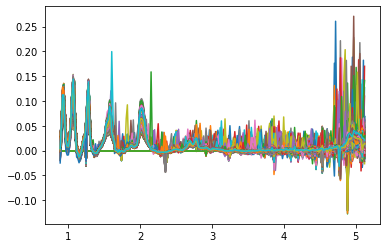

In [10]:
%matplotlib inline
plt.figure(facecolor='white')
for spectrum in spectrum_filter_3:
    plt.plot(vims_wave,spectrum)
plt.show()

In [13]:
spectrum_filter_4 = []
ettime_filter_4 = []
for (spectrum,time) in zip(spectrum_filter_3,ettime_filter_3):
    std = np.std(spectrum[230:256])
    ind = np.where((spectrum[230:256]>=0.06)|(spectrum[230:256]<=0.04)) # Center of filter at .0125
    if len(ind) == 0 or std<.012:
        spectrum_filter_4.append(spectrum)
        ettime_filter_4.append(time)

print(np.shape(spectrum_filter_4))
print(np.shape(ettime_filter_4))
    

(9931, 256)
(9931,)


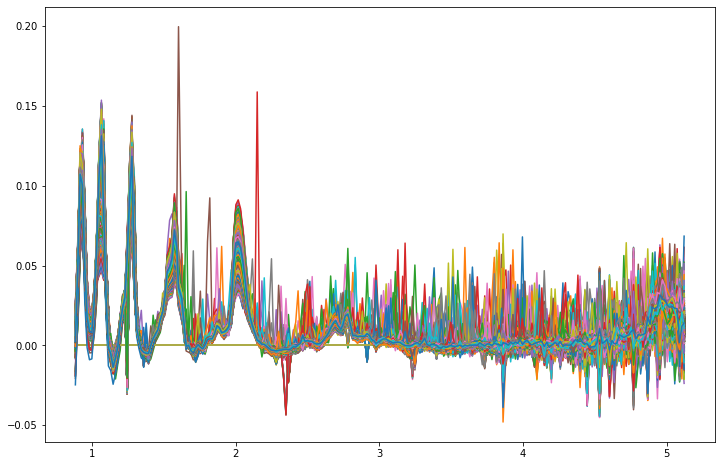

In [32]:
%matplotlib inline
plt.figure(facecolor='white',figsize=(12,8))
for spectrum in spectrum_filter_4:
    plt.plot(vims_wave,spectrum)
plt.show()

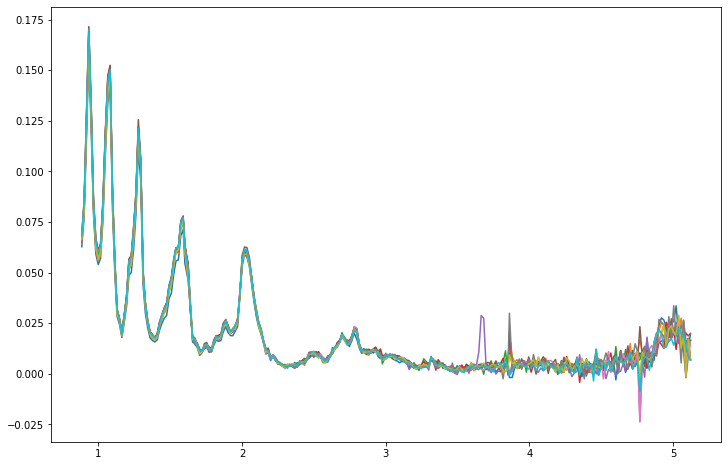

In [29]:
%matplotlib inline
plt.figure(facecolor='white',figsize=(12,8))
for spectrum in total_spectrum[:10]:
    plt.plot(vims_wave,spectrum)
plt.show()

In [31]:
tot = 0
for spectrum in total_spectrum:
    ind = np.where(spectrum < 0)[0]
    if len(ind) > 0:
        tot += 1
print(tot)

11057


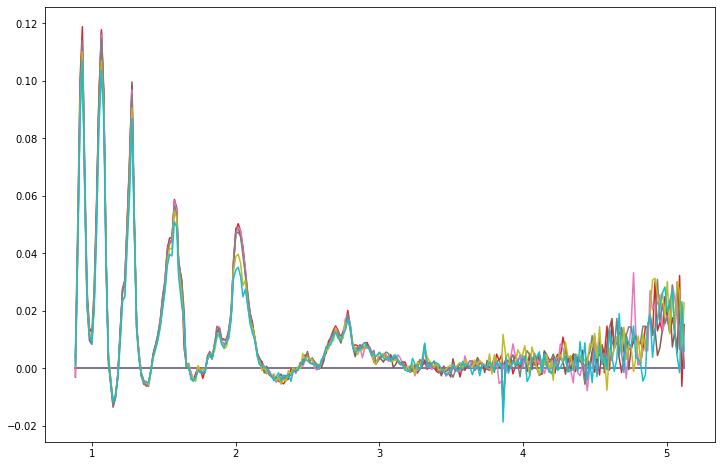

In [14]:
%matplotlib inline
plt.figure(facecolor='white',figsize=(12,8))
for spectrum in spectrum_filter_4[5421:5431]:
    plt.plot(vims_wave,spectrum)
plt.show()

### **Idea**: For "cleaning" each of the first few spectral peaks, should we fit a general gaussain to all of the data and exlcude all spectra that lay outside it for each respective window?

In [26]:
spectrum_filter_5 = []
ettime_filter_5 = []
for (spectrum,time) in zip(spectrum_filter_4,ettime_filter_4):
    ind = np.where(spectrum<0)[0]
    if len(ind) > 0:
        spectrum_filter_5.append(spectrum)
        ettime_filter_5.append(time)

print(np.shape(spectrum_filter_5))
print(np.shape(ettime_filter_5))

(9931, 256)
(9931,)


In [19]:
print(np.shape(np.where(spectrum_filter_4[3214]<0))[1])

49


In [21]:
spectrum_filter_4[3214]

array([ 4.30635971e-03,  3.58162753e-02,  7.92834451e-02,  1.14339561e-01,
        7.23086847e-02,  3.03005215e-02,  1.51031505e-02,  1.20023619e-02,
        2.10378082e-02,  4.54421245e-02,  8.00999649e-02,  1.05445076e-01,
        1.01272258e-01,  4.33907344e-02,  1.14014087e-02, -4.40238359e-03,
       -9.12314801e-03, -1.06453019e-02, -2.84347508e-03,  8.86069430e-03,
        2.51453555e-02,  2.63850384e-02,  4.28838360e-02,  6.01593348e-02,
        8.96514422e-02,  6.04973128e-02,  1.71598196e-02,  6.10209105e-03,
       -5.39947875e-04, -3.96688524e-03, -4.93790072e-03, -4.77489913e-03,
       -2.10127281e-03,  3.54021693e-03,  6.48526363e-03,  1.04577200e-02,
        1.40667700e-02,  2.20166539e-02,  2.66015050e-02,  3.59469614e-02,
        3.97743551e-02,  3.97871545e-02,  5.32636707e-02,  5.32260151e-02,
        3.82309035e-02,  3.10267160e-02,  1.25040242e-02,  1.14812697e-03,
        6.03583642e-04, -1.61284744e-03, -3.14488459e-03, -3.29038103e-03,
        1.21123528e-04,  

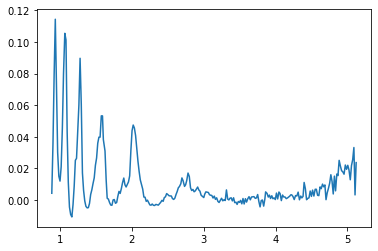

In [25]:
%matplotlib inline
plt.figure(facecolor='white')
plt.plot(vims_wave,spectrum_filter_4[3214])
plt.show()

In [ ]:
total_s